In [46]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision

from iobs.simulators import make_n_disk
from iobs.layers import IOBLayer
from iobs.models import BaseAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)

Device: mps


# Generate dataset

In [3]:
# generate images
dim = 32
data = make_n_disk(
    n_samples=10000,
    n_disks=2,
    dim=dim,
    verbose=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 28506.19it/s]


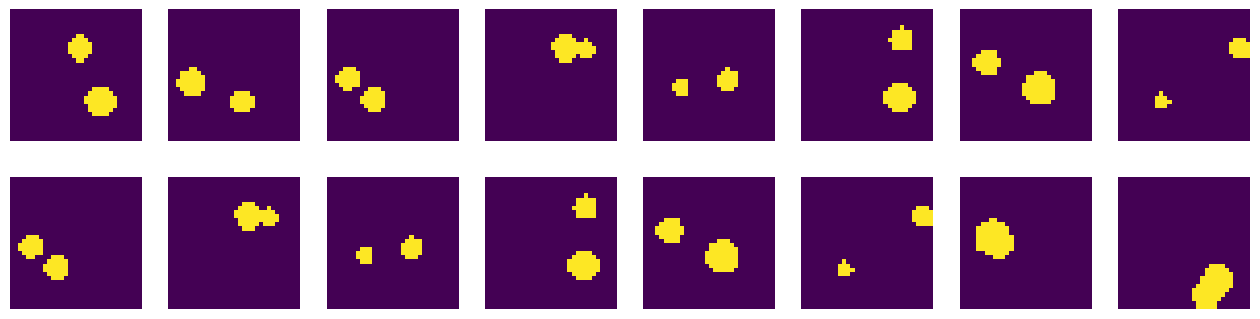

In [4]:
# plot examples
N, M = 2,8
f, axs = plt.subplots(N, M, figsize=(2*M, 2*N))

inds = np.random.choice(len(data), size=N*M, replace=False)
for i in range(N):
    for j in range(M):
        axs[i,j].imshow(data[inds[i*N+j]])
        axs[i,j].axis('off')

In [5]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [6]:
# create dataset and dataloaders
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5, 0.5)]
)
itransform = torchvision.transforms.Normalize(-0.5, 2)
class SimulatedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx]

train_dataset = SimulatedDataset(data[in_train], transform=transform)
val_dataset = SimulatedDataset(data[in_val], transform=transform)
test_dataset = SimulatedDataset(data[in_test], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define encoder-decoder architecture

In [7]:
def build_dense_sequence(shape_list):
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

encoder = nn.Sequential(
    nn.Conv2d(1, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(12, 24, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Conv2d(24, 48, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.Flatten(),
    *(build_dense_sequence([768, 256, 128, 16])),
#     nn.ReLU()
).to(device)

decoder = nn.Sequential(
    *(build_dense_sequence([16, 128, 256, 768])),
    nn.Unflatten(dim=1,
                 unflattened_size=(48, 4, 4)),
    nn.ConvTranspose2d(48, 24, 4,
                       stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
    nn.ReLU(True),
    nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),
).to(device)

bottleneck = IOBLayer(16, device=device)

In [8]:
model = BaseAE(
    input_shape=(dim, dim),
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [9]:
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

# Train

In [10]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 5e-5

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [11]:
trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()
    trloss = trloss / len(train_loader)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()
        valoss = valoss / len(val_loader)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    print(f"epoch : {epoch + 1}/{max_epochs}, "
          f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

epoch : 1/3000, loss = 0.763639, val loss = 0.481490
epoch : 2/3000, loss = 0.397629, val loss = 0.357118
epoch : 3/3000, loss = 0.338060, val loss = 0.323689
epoch : 4/3000, loss = 0.313441, val loss = 0.305398
epoch : 5/3000, loss = 0.298928, val loss = 0.293678
epoch : 6/3000, loss = 0.289093, val loss = 0.285433
epoch : 7/3000, loss = 0.282501, val loss = 0.281337
epoch : 8/3000, loss = 0.279322, val loss = 0.279476
epoch : 9/3000, loss = 0.278256, val loss = 0.277797
epoch : 10/3000, loss = 0.274448, val loss = 0.269943
epoch : 11/3000, loss = 0.265061, val loss = 0.263451
epoch : 12/3000, loss = 0.259403, val loss = 0.254789
epoch : 13/3000, loss = 0.248030, val loss = 0.242632
epoch : 14/3000, loss = 0.235271, val loss = 0.231318
epoch : 15/3000, loss = 0.226298, val loss = 0.223296
epoch : 16/3000, loss = 0.217411, val loss = 0.214497
epoch : 17/3000, loss = 0.209387, val loss = 0.207118
epoch : 18/3000, loss = 0.202194, val loss = 0.200309
epoch : 19/3000, loss = 0.196451, val

epoch : 152/3000, loss = 0.105588, val loss = 0.108245
epoch : 153/3000, loss = 0.105421, val loss = 0.107741
epoch : 154/3000, loss = 0.105230, val loss = 0.107735
epoch : 155/3000, loss = 0.105332, val loss = 0.108097
epoch : 156/3000, loss = 0.105061, val loss = 0.107582
epoch : 157/3000, loss = 0.104902, val loss = 0.107417
epoch : 158/3000, loss = 0.104897, val loss = 0.107142
epoch : 159/3000, loss = 0.104502, val loss = 0.107207
epoch : 160/3000, loss = 0.104453, val loss = 0.107150
epoch : 161/3000, loss = 0.104481, val loss = 0.107229
epoch : 162/3000, loss = 0.104371, val loss = 0.106782
epoch : 163/3000, loss = 0.104121, val loss = 0.106817
epoch : 164/3000, loss = 0.104080, val loss = 0.106823
epoch : 165/3000, loss = 0.104106, val loss = 0.107164
epoch : 166/3000, loss = 0.103837, val loss = 0.106579
epoch : 167/3000, loss = 0.103779, val loss = 0.106235
epoch : 168/3000, loss = 0.103559, val loss = 0.106668
epoch : 169/3000, loss = 0.103454, val loss = 0.106356
epoch : 17

epoch : 301/3000, loss = 0.094809, val loss = 0.098912
epoch : 302/3000, loss = 0.094929, val loss = 0.098894
epoch : 303/3000, loss = 0.094594, val loss = 0.098727
epoch : 304/3000, loss = 0.094704, val loss = 0.098580
epoch : 305/3000, loss = 0.094653, val loss = 0.099181
epoch : 306/3000, loss = 0.094662, val loss = 0.099414
epoch : 307/3000, loss = 0.094636, val loss = 0.098398
epoch : 308/3000, loss = 0.094421, val loss = 0.098738
epoch : 309/3000, loss = 0.094515, val loss = 0.099168
epoch : 310/3000, loss = 0.094431, val loss = 0.099041
epoch : 311/3000, loss = 0.094327, val loss = 0.098884
epoch : 312/3000, loss = 0.094484, val loss = 0.098855
epoch : 313/3000, loss = 0.094295, val loss = 0.098760
epoch : 314/3000, loss = 0.094143, val loss = 0.098297
epoch : 315/3000, loss = 0.094143, val loss = 0.098160
epoch : 316/3000, loss = 0.094159, val loss = 0.098374
epoch : 317/3000, loss = 0.094020, val loss = 0.098477
epoch : 318/3000, loss = 0.094143, val loss = 0.098701
epoch : 31

epoch : 450/3000, loss = 0.090498, val loss = 0.096136
epoch : 451/3000, loss = 0.090477, val loss = 0.095593
epoch : 452/3000, loss = 0.090077, val loss = 0.095428
epoch : 453/3000, loss = 0.090354, val loss = 0.095823
epoch : 454/3000, loss = 0.090583, val loss = 0.096295
epoch : 455/3000, loss = 0.090489, val loss = 0.095482
epoch : 456/3000, loss = 0.090384, val loss = 0.095301
epoch : 457/3000, loss = 0.090146, val loss = 0.095766
epoch : 458/3000, loss = 0.090466, val loss = 0.095477
epoch : 459/3000, loss = 0.090234, val loss = 0.095731
epoch : 460/3000, loss = 0.090236, val loss = 0.095398
epoch : 461/3000, loss = 0.090253, val loss = 0.095136
epoch : 462/3000, loss = 0.090197, val loss = 0.095656
epoch : 463/3000, loss = 0.090348, val loss = 0.095549
epoch : 464/3000, loss = 0.090233, val loss = 0.095464
epoch : 465/3000, loss = 0.090116, val loss = 0.095973
epoch : 466/3000, loss = 0.090215, val loss = 0.095454
epoch : 467/3000, loss = 0.090174, val loss = 0.095223
epoch : 46

Text(0.5, 0, 'Epoch')

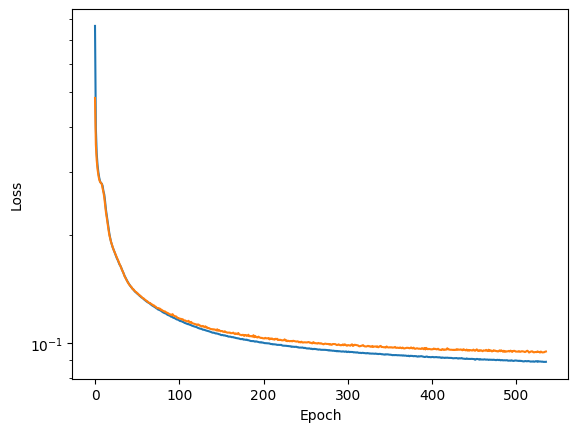

In [16]:
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

# Test

In [33]:
test_data = test_dataset.data
recon_data = np.zeros_like(test_data)
recon_data = np.repeat(recon_data[:,None,...], repeats=model.latent_dim+1, axis=1)

with torch.no_grad():
    i = 0
    for j, batch_features in enumerate(test_loader):
        batch_features = batch_features.float().to(device)
        recon_data[i:i+len(batch_features)] = \
            itransform(model.forward_all(batch_features).detach().cpu()[:,:,0,...,None])
        i += len(batch_features)

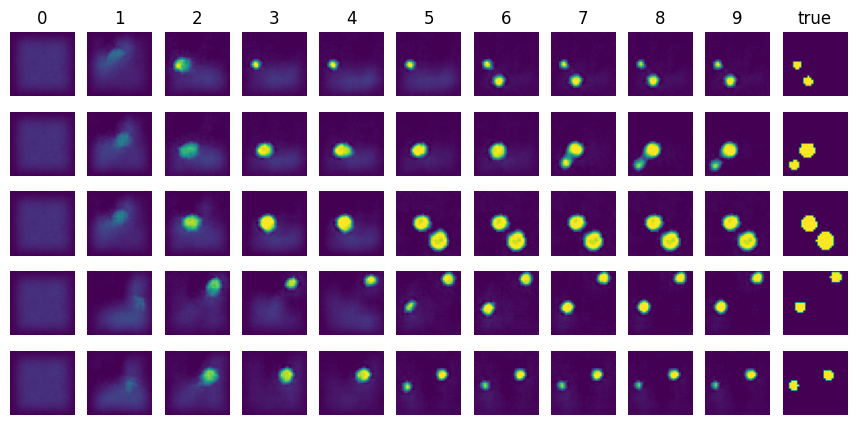

In [38]:
N = 5
max_n_open = 9

f, axs = plt.subplots(N, max_n_open+2, figsize=(max_n_open*1.2, N))
inds = np.random.choice(len(test_data), size=N, replace=False)
for i in range(N):
    for j in range(max_n_open+1):
        axs[i,j].imshow(recon_data[inds[i], j], vmin=0, vmax=1)
        axs[i,j].axis('off')   
    
    axs[i,-1].imshow(test_data[inds[i]], vmin=0, vmax=1)
    axs[i,-1].axis('off')
        
axs[0,-1].set_title('true')
for j in range(max_n_open+1):
    axs[0,j].set_title(j)

Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

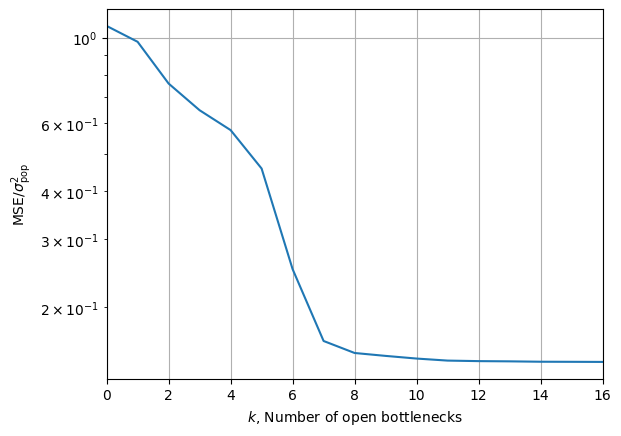

In [42]:
testvar = np.sum(np.var(test_data, axis=0).shape)
test_percerr = np.sum(np.mean((recon_data-test_data[:,None])**2, axis=0), axis=(1,2,3))/testvar

f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

# Calculate intrinsic dimensionality

In [50]:
p = 0.05

diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(~(diff_loglik<chi2.isf(p,1))).max()
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 7
